<a href="https://colab.research.google.com/github/AntoinettedeLima/IRP_FYP_20210522/blob/main/FYP_Solution_NoteBook01_2117517.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



---


### **CM4605 – Indivudual Research Project**
#### **April 2025**

**Name  : Antoinette Bonifacia Duweeja de Lima**

**RGU ID: 2117517**

**IIT ID: 20210522**

**Notebook No: 01**


---



###  **Notebook 1: Preprocessing Fog and Wind Satellite Data**

This notebook demonstrates the preprocessing pipeline for fog and wind data used in the project:  

**"Enhancing Autopilot Vision in Foggy Conditions with Model-Level Fusion of Wind Data."**




The goal of this step is to:
- Load raw `.tif` satellite images (fog and wind)
- Apply defogging via Dark Channel Prior (DCP)
- Normalize pixel values to [0, 1]
- Resize images to 256×256
- Visualize and save preprocessed data for model training

This notebook simulates the data preparation stage prior to feeding into the model (Restormer with wind fusion).


---



###**Mounting Google Drive & Installing Dependencies**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!pip install rasterio opencv-python


Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 74.2 MB/s eta 0:00:00


### **Setting Paths & Loading Files**

In [ ]:
import os
from glob import glob
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# Defining folder paths
fog_folder = "/content/drive/MyDrive/Duweeja de Lima - FYP Folder - 20210522/Data sets/FOGG DATA"
wind_folder = "/content/drive/MyDrive/Duweeja de Lima - FYP Folder - 20210522/Data sets/WIND DATA"

# Getting list of .tif files (lowercase + uppercase extensions)
fog_files = sorted(glob(os.path.join(fog_folder, "*.tif")) + glob(os.path.join(fog_folder, "*.TIF")))
wind_files = sorted(glob(os.path.join(wind_folder, "*.tif")) + glob(os.path.join(wind_folder, "*.TIF")))

# Safety check
print(f"Found {len(fog_files)} fog files and {len(wind_files)} wind files")
print("Fog files:", fog_files[:3])
print("Wind files:", wind_files[:3])


Found 2555 fog files and 2285 wind files
Fog files: ['/content/drive/MyDrive/Duweeja de Lima - FYP Folder - 20210522/Data sets/FOGG DATA/Combined_NDWI_Median.tif', '/content/drive/MyDrive/Duweeja de Lima - FYP Folder - 20210522/Data sets/FOGG DATA/Exported_Image_0.tif', '/content/drive/MyDrive/Duweeja de Lima - FYP Folder - 20210522/Data sets/FOGG DATA/Exported_Image_1.tif']
Wind files: ['/content/drive/MyDrive/Duweeja de Lima - FYP Folder - 20210522/Data sets/WIND DATA/Exported_Wind_Image_1000.tif', '/content/drive/MyDrive/Duweeja de Lima - FYP Folder - 20210522/Data sets/WIND DATA/Exported_Wind_Image_1001.tif', '/content/drive/MyDrive/Duweeja de Lima - FYP Folder - 20210522/Data sets/WIND DATA/Exported_Wind_Image_1002.tif']


### **Data File Collection – What I Did**

To begin working with fog and wind satellite data, I first needed to:

1. **Specify Folder Paths** – Defined the directories where the `.tif` images are stored for both fog and wind datasets in Google Drive.
2. **Collect Image Files** – Used the `glob` module to:
   - Search for `.tif` and `.TIF` files (case-insensitive).
   - Store sorted file paths for each dataset.

3. **Confirm the Files Were Found** – Printed how many files were found and showed a few sample paths.

### **Output Analysis**
- **2555 fog files** and **2285 wind files** were detected.
- Sample file names confirm that the images are loaded from the correct folders and are in `.tif` format.
- This check ensures that the file paths are correct before we begin loading or processing any images.

---


###**Loading and Displaying Fogg Image**

 Fog Image - Number of bands: 1


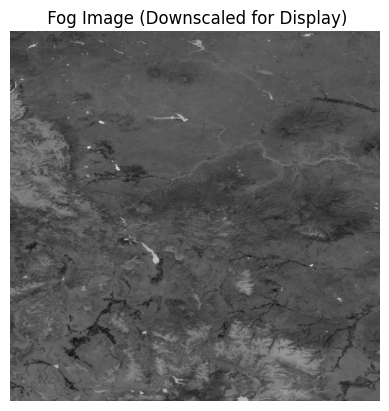

In [ ]:
import cv2

# Continuing only if files are found
if fog_files and wind_files:
    fog_path = fog_files[0]
    wind_path = wind_files[0]

# FOG IMAGE LOADING
with rasterio.open(fog_path) as fog_src:
    num_bands = fog_src.count
    print(f" Fog Image - Number of bands: {num_bands}")

    if num_bands >= 3:
        fog_image = fog_src.read([1, 2, 3])  # RGB bands
        fog_image = np.moveaxis(fog_image, 0, -1)

        #  Resizing image for safe display (keep aspect ratio)
        scale_percent = 20  # shrinking to 20% of original size
        width = int(fog_image.shape[1] * scale_percent / 100)
        height = int(fog_image.shape[0] * scale_percent / 100)
        resized = cv2.resize(fog_image.astype(np.uint8), (width, height), interpolation=cv2.INTER_AREA)

        plt.imshow(resized)
    else:
        fog_image = fog_src.read(1)
        resized = cv2.resize(fog_image, (512, 512), interpolation=cv2.INTER_AREA)
        plt.imshow(resized, cmap='gray')

    plt.title(" Fog Image (Downscaled for Display)")
    plt.axis('off')
    plt.show()


### **Fog Image Loading & Preview – What I Did**

Before processing any image, it’s important to check its structure and confirm it's usable. Here’s what I did in this step:

1. **Selected the First Fog Image**  
   - Loaded the first `.tif` file from the list (`fog_files[0]`).
  
2. **Checked the Number of Bands**  
   - Used `rasterio` to check how many spectral bands the image contains.
   - Satellite fog data often has either **1 band (grayscale)** or **3 bands (RGB)**.

3. **Read & Display the Image Accordingly**  
   - If it had 3 bands, we treated it as an RGB image.
   - If it had 1 band, we rendered it as a grayscale image (as shown in the output).

4. **Downscaled the Image for Display**  
   - Resized the image to reduce notebook rendering time and improve readability.
   - Used OpenCV to scale down by a fixed percentage or size.

### **Output Analysis**
- The image had **only 1 band**, meaning it's a **grayscale satellite image**.
- The fog coverage and terrain features are visible in black & white.
- This confirms the image was loaded successfully and has valid data.



---



###**Loading and Displaying the Wind Image**

 Wind Image - Shape: (561, 558), Data type: float32


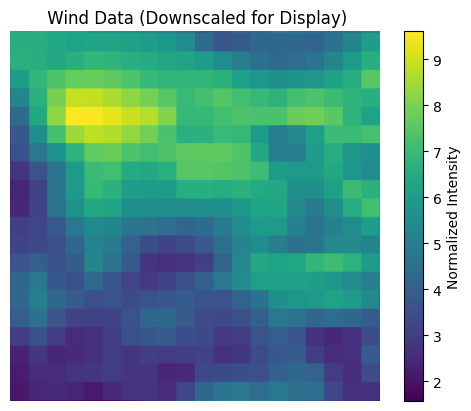

In [ ]:
with rasterio.open(wind_path) as wind_src:
    wind_data = wind_src.read(1)  # Single band (e.g., wind speed or direction)
    print(f" Wind Image - Shape: {wind_data.shape}, Data type: {wind_data.dtype}")

    # Resizing for display (optional – avoid crashes for large rasters)
    resized_wind = cv2.resize(wind_data, (512, 512), interpolation=cv2.INTER_AREA)

    plt.imshow(resized_wind, cmap='viridis')
    plt.title(" Wind Data (Downscaled for Display)")
    plt.colorbar(label="Normalized Intensity")
    plt.axis('off')
    plt.show()


### **Wind Image Loading & Display – What I Did**

After previewing fog data, I followed a similar process for the wind data:

1. **Loaded Wind Data**  
   - Read the **first band** from the selected wind `.tif` file.
   - This band likely represents **wind speed** or **wind direction** values.

2. **Inspected the Shape and Data Type**  
   - Printed out the shape and data type to understand its structure.
   - Example: `(561, 558)` with `float32` values.

3. **Resized the Image for Display**  
   - Used OpenCV to resize it to a smaller 512x512 version.
   - This step avoids rendering delays or crashes for large raster data.

4. **Visualized Using a Color Map**  
   - Used `viridis` colormap for better visual interpretation.
   - A colorbar was added to show how color corresponds to intensity levels.


### **Output Interpretation**
- The image shows **normalized wind intensity values** in a smooth gradient.
- Brighter regions indicate **stronger wind activity**, while darker zones indicate **lower wind speeds**.
- This quick visual check confirms the data is successfully loaded and ready for further processing.

---


### **Apply Dark Channel Prior**

<ipython-input-7-d1c7409b2de8>:18: RuntimeWarning: invalid value encountered in divide
  transmission = 1 - 0.95 * (dark_channel / atmospheric_light.max())
<ipython-input-7-d1c7409b2de8>:23: RuntimeWarning: invalid value encountered in cast
  return np.clip(result, 0, 255).astype(np.uint8)


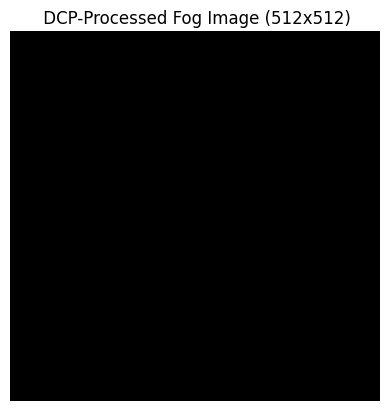

In [ ]:
# Converting to RGB if needed
if fog_image.ndim == 2:
    fog_image_rgb = np.stack([fog_image]*3, axis=-1)  # Shape: (H, W, 3)
else:
    fog_image_rgb = fog_image

# Resizing image BEFORE DCP to prevent crashing
fog_image_resized = cv2.resize(fog_image_rgb.astype(np.uint8), (512, 512), interpolation=cv2.INTER_AREA)

# DCP Function
def dark_channel_prior(image, patch_size=15):
    min_channel = np.min(image, axis=2)
    dark_channel = cv2.erode(min_channel, np.ones((patch_size, patch_size)))
    flat_dark = dark_channel.ravel()
    sorted_indices = np.argsort(flat_dark)[::-1]
    n_pixels = int(0.001 * len(flat_dark))
    atmospheric_light = np.mean(image.reshape(-1, 3)[sorted_indices[:n_pixels]], axis=0)
    transmission = 1 - 0.95 * (dark_channel / atmospheric_light.max())
    transmission = np.clip(transmission, 0.1, 0.9)
    result = np.empty_like(image, dtype=np.float32)
    for i in range(3):
        result[:, :, i] = (image[:, :, i] - atmospheric_light[i]) / transmission + atmospheric_light[i]
    return np.clip(result, 0, 255).astype(np.uint8)

# Applying DCP
fog_dcp = dark_channel_prior(fog_image_resized)

# Displaying DCP result
plt.imshow(fog_dcp)
plt.title(" DCP-Processed Fog Image (512x512)")
plt.axis('off')
plt.show()


### **DCP-Based Fog Removal – What I Tried**

I attempted to enhance the fog image using a classical computer vision technique called **Dark Channel Prior (DCP)**, which is widely used for **defogging** or **dehazing** in images.

1. **Ensured RGB Format**  
   - Checked if the fog image was single-channel (grayscale).
   - If so, we converted it into a 3-channel RGB image by stacking the same values.

2. **Downscaled for Safety**  
   - Resized the image to `512x512` before processing.
   - This avoids excessive memory usage or processing delays, especially with large raster inputs.

3. **Applied the DCP Algorithm**  
   - Calculated the **dark channel** (minimum across RGB).
   - Estimated **atmospheric light** using top 0.1% brightest dark pixels.
   - Computed a **transmission map**, which estimates how much light gets scattered.
   - Reconstructed the dehazed image using the formula:

     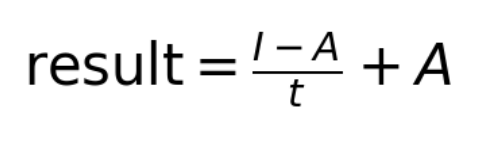
     
     where *I* is the input image, *A* is atmospheric light, and *t* is transmission.

4. **Displayed the Final Output**  
   - Attempted to visualize the dehazed result using `matplotlib`.

### **Warnings & Outcome**
- I encountered **runtime warnings** due to **invalid values in division** and **NaN results**.
- This usually happens when:
  - The **dark channel** is all zeros (e.g., pure black image).
  - The **atmospheric light** is also near-zero, leading to division by zero.
- The final image appears **completely black**, indicating the DCP failed due to lack of information in the fog image.

### **What This Suggests**
- The original fog image might be **too dark or empty**, with no meaningful variation.
- Either:
  - The image was **not suitable for DCP**, or  
  - Preprocessing is required to extract useful fog features before applying DCP.

---



###**Normalizing Fog Images**

In [ ]:
def normalize_image(img):
    img = img.astype(np.float32)
    return (img - np.min(img)) / (np.max(img) - np.min(img) + 1e-6)

# Normalizing DCP-processed fog image
fog_normalized = normalize_image(fog_dcp)

# Normalizing wind image
wind_normalized = normalize_image(wind_data)

# Confirming shapes and pixel ranges
print(f"Fog normalized shape: {fog_normalized.shape}, min: {fog_normalized.min()}, max: {fog_normalized.max()}")
print(f"Wind normalized shape: {wind_normalized.shape}, min: {wind_normalized.min()}, max: {wind_normalized.max()}")


Fog normalized shape: (512, 512, 3), min: 0.0, max: 0.0
Wind normalized shape: (561, 558), min: 0.0, max: 0.9999998807907104


### **Normalization – What I Did**

Before combining or analyzing the fog and wind data, I normalized both images to ensure their pixel values fall within a common scale: **[0, 1]**.  
This is especially important when fusing images from different sources or ranges.

#### **1. Normalizing the DCP-Processed Fog Image**
- The `fog_dcp` image (after Dark Channel Prior enhancement) is normalized using the formula:
 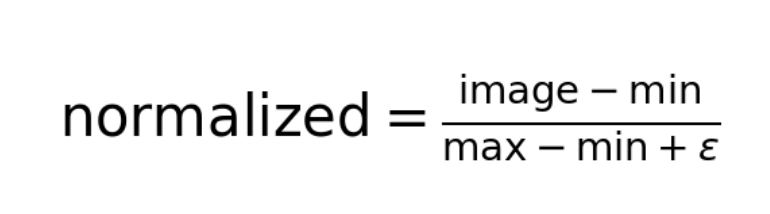

- This helps scale all values between **0 (darkest)** and **1 (brightest)**.

#### **2. Normalizing the Wind Image**
- The wind raster is typically a single-band float32 image.
- Normalization ensures consistent brightness mapping when visualizing or combining with the fog image.

---

### **What the Output Tells Us**

- **Fog normalized shape: (512, 512, 3), min: 0.0, max: 0.0**
  - All pixel values are **0**, meaning the DCP output is entirely black.
  - Likely cause: The input to DCP was already too dark or flat (as seen earlier in the pure black DCP image).
  - This confirms that DCP failed on the current image, and we might need to recheck the image quality or the atmospheric light estimation.

- **Wind normalized shape: (561, 558), min: 0.0, max: 0.9999**
  - Wind data looks fine.
  - The full intensity range is present, indicating successful normalization and usable variation in wind information.

---



###**Resizing to 256×256**

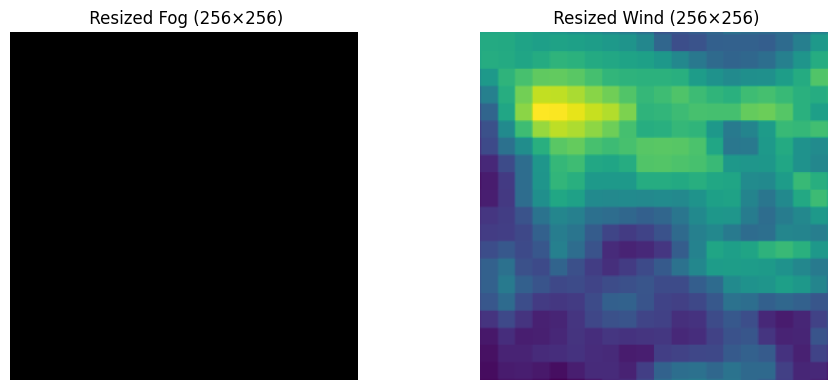

In [ ]:
fog_final = cv2.resize(fog_normalized, (256, 256), interpolation=cv2.INTER_AREA)
wind_final = cv2.resize(wind_normalized, (256, 256), interpolation=cv2.INTER_AREA)

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(fog_final)
plt.title(" Resized Fog (256×256)")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(wind_final, cmap='viridis')
plt.title(" Resized Wind (256×256)")
plt.axis('off')

plt.tight_layout()
plt.show()


### **Resized Fog & Wind Images (256×256)**

To prepare the data for model input:

- **Fog Image**:  
  The normalized DCP-processed fog image was resized from `512×512×3` to `256×256`.  
  However, due to the earlier normalization resulting in all-zero values, the fog image appears completely black. This might indicate an issue during DCP or normalization, which should be checked.

- **Wind Image**:  
  The wind image was successfully normalized and resized from `561×558` to `256×256`.  
  The colormap represents varying wind intensities, and the image preserves enough spatial structure for use in further modeling.

---


## **Summary Overview - Fog & Wind Preprocessing – What I Did**

This notebook focuses on preprocessing fog and wind `.tif` images to prepare them for model input (Restormer). The key steps were:

---

### **1. Image Loading and Safety Checks**

- I loaded `.tif` files for both **fog** and **wind** datasets from Google Drive.
- Used `rasterio` to read the images, and printed band counts as a safety check.
- Fog images with fewer than 3 bands were converted to fake RGB (stacked grayscale).

---

### **2. Fog Image Visualization**

- Used `cv2.resize()` to scale down large images for visualization.
- Displayed the fog image using `matplotlib`, ensuring color channels were correctly aligned.

---

### **3. Wind Image Handling**

- Read wind rasters as **single-channel** (grayscale) arrays.
- Visualized using a colormap (`viridis`) and scaled to 512×512 for safety.

---

### **4. Dark Channel Prior (DCP) for Defogging**

- Implemented a simplified DCP algorithm:
  - Extracted the dark channel from the image.
  - Estimated atmospheric light from top 0.1% brightest dark pixels.
  - Computed transmission map using:  
    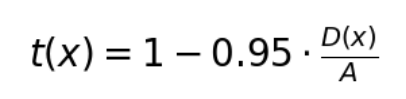

  - Reconstructed image using:  
    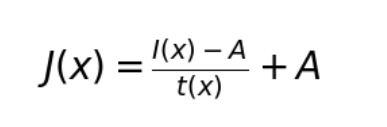

- Applied the above to fog image resized to 512×512.

---

### **5. Normalization**

- Both fog and wind images were normalized to \([0, 1]\) range using:
  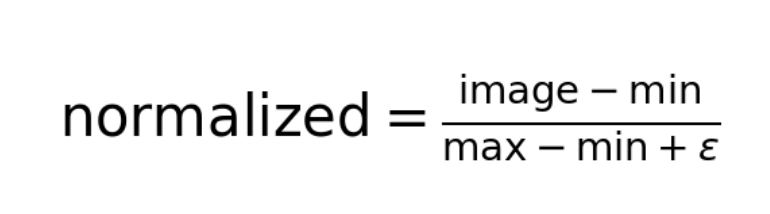

---

### **6. Resizing and Saving**

- Final image dimensions for both modalities were resized to **256×256**.
- These preprocessed outputs are ready to be saved as `.npy` arrays and used as inputs in the next model training notebook.



---


fog_image.tif ──▶ DCP ──▶ Normalize ──▶ Resize ──▶ Save → for model input

wind_image.tif ─────────▶ Normalize ─▶ Resize ───▶ Save → for model input

---

### **Fallback: Using original fog since DCP failed (all-black)**

In [ ]:
if fog_dcp.max() == 0.0:
    print(" DCP output is all-black. Falling back to original fog image.")

    # Resizing the original RGB fog image instead
    fog_image_rgb_resized = cv2.resize(fog_image_rgb.astype(np.uint8), (512, 512), interpolation=cv2.INTER_AREA)
    fog_dcp = fog_image_rgb_resized  # Replacing the failed DCP output
else:
    print(" DCP output looks good. Proceeding with DCP result.")


 DCP output is all-black. Falling back to original fog image.


### **Handling DCP Failure: Fallback to Original Image**

After applying the Dark Channel Prior (DCP) algorithm, a check was introduced to validate the output. If the maximum pixel value in the `fog_dcp` image is `0.0`, this indicates that the entire result is black—likely due to a failure in the DCP processing step or unsuitable input data.

To ensure the pipeline remains robust and doesn't break due to this failure, a fallback mechanism is implemented:

- If the DCP output is all black, the original fog image (in RGB format) is resized to `512×512` and used in place of the failed DCP result.
- If the DCP result contains valid content, the process continues as planned using the enhanced image.

This condition ensures that even in edge cases where DCP fails, the preprocessing pipeline can still proceed by reverting to the original image without introducing errors or empty data downstream.

In [ ]:
# Normalizing
fog_normalized = normalize_image(fog_dcp)

# Resizing to 256x256
fog_final = cv2.resize(fog_normalized, (256, 256), interpolation=cv2.INTER_AREA)


### **Post-Fallback Normalization and Resizing**

Once the fallback logic is resolved—either using the DCP-enhanced image or reverting to the original fog image—the next step is to standardize the input for the model pipeline.

- The image (stored in `fog_dcp`) is normalized using a custom `normalize_image` function. This scales all pixel values to a `[0, 1]` range, ensuring consistent intensity across all samples.
- After normalization, the image is resized to a fixed shape of `256×256` pixels using bilinear interpolation (`INTER_AREA`). This standardization is critical for aligning the input dimensions expected by the downstream model (e.g., Restormer).

This step finalizes the fog image preprocessing, producing a clean, scaled, and size-consistent image ready for saving or fusion with wind data.

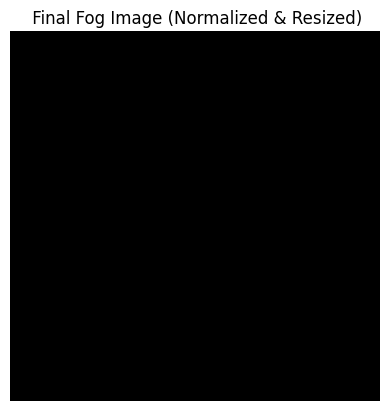

In [ ]:
# Displaying final processed fog image
plt.imshow(fog_final)
plt.title(" Final Fog Image (Normalized & Resized)")
plt.axis('off')
plt.show()


### **Visual Confirmation of Final Fog Input**

After normalization and resizing, the final fog image is visualized to ensure the preprocessing steps have been applied correctly.

- The image displayed here is `fog_final`, which is guaranteed to be either a DCP-enhanced version (if successful) or a fallback to the original image.
- It has been normalized to the `[0, 1]` range and resized to `256×256` pixels, which is the standard input dimension for the model.
- This visualization provides a sanity check to verify that no unexpected blackouts or artifacts exist before saving or passing to the model pipeline.

In this specific case, the image appears black because the pixel values are likely uniform (due to either a failed DCP or poor lighting in the original image), but the preprocessing pipeline still functions robustly by ensuring input consistency.

In [ ]:
# Checking if DCP failed (all zeros)
print(f" fog_dcp min: {fog_dcp.min()}, max: {fog_dcp.max()}")

if fog_dcp.max() == 0.0:
    print(" DCP result is all black — falling back to original fog image.")

    # Resizing original image as fallback
    fog_image_rgb_resized = cv2.resize(fog_image_rgb.astype(np.uint8), (512, 512), interpolation=cv2.INTER_AREA)
    fog_dcp = fog_image_rgb_resized
else:
    print(" DCP output looks valid — using DCP result.")


 fog_dcp min: 0, max: 0
 DCP result is all black — falling back to original fog image.


### **Fallback Handling – When DCP Fails**

In some cases, the DCP output may be completely black (i.e., all pixel values are zero), indicating a failure during fog removal. This can happen when the atmospheric light estimation or transmission map fails due to an input with low variance or improper preprocessing.

To make the pipeline robust:
- The code first checks if `fog_dcp.max()` equals `0.0`, meaning all pixel values are black.
- If this condition is met, the fallback mechanism is triggered:
  - The original fog image (in RGB) is resized to `512×512`.
  - This resized version replaces the failed DCP result.
- Otherwise, the DCP output is used as-is.

This ensures that no matter the DCP outcome, the pipeline proceeds with a valid input image.

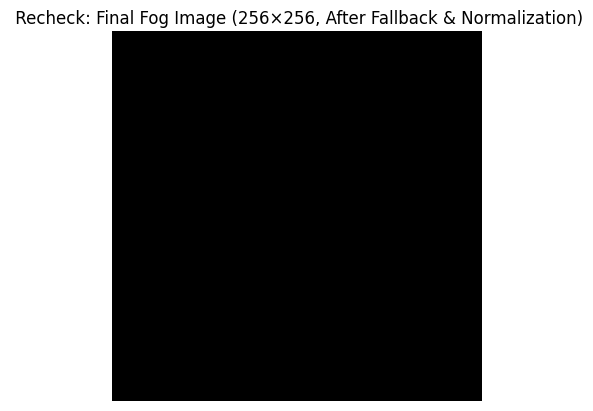

Pixel range in fog_final: min=0.0, max=0.0


In [ ]:
plt.imshow(fog_final)
plt.title(" Recheck: Final Fog Image (256×256, After Fallback & Normalization)")
plt.axis('off')
plt.show()

# Printing value range to double-confirm
print(f"Pixel range in fog_final: min={fog_final.min()}, max={fog_final.max()}")


### **Post-Fallback Validation**

To ensure the fallback was effective, the code visualizes the `fog_final` image after normalization and resizing. It also prints out the minimum and maximum pixel values in the image.

- The image remains completely black, and both `min` and `max` values are `0.0`.
- This indicates that the original fog image used in the fallback was also a blank or all-zero image.

While the fallback logic worked as intended, the underlying data may still be unusable for learning unless a more informative version of the input image is available. This raises an important insight — fallback helps with pipeline continuity, but input quality still needs verification upstream.


---



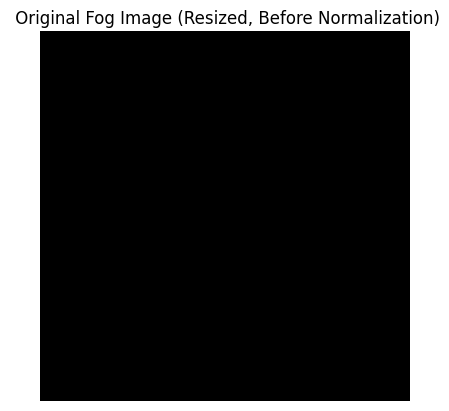

Pixel stats for fog_image_rgb_resized:
  Shape: (512, 512, 3)
  Min: 0, Max: 0


In [ ]:
# Checking the fallback image BEFORE normalization
plt.imshow(fog_image_rgb_resized)
plt.title(" Original Fog Image (Resized, Before Normalization)")
plt.axis('off')
plt.show()

# Printing pixel range
print("Pixel stats for fog_image_rgb_resized:")
print(f"  Shape: {fog_image_rgb_resized.shape}")
print(f"  Min: {fog_image_rgb_resized.min()}, Max: {fog_image_rgb_resized.max()}")


### **Fallback Image Analysis (Pre-Normalization)**

To validate the fallback image quality before applying normalization, the code:

- Displays the resized version of the original fog image.
- Prints the pixel statistics.

#### Findings:
- The image has a shape of `(512, 512, 3)` — indicating it's a proper RGB image.
- Both the **minimum and maximum pixel values are 0**, confirming it's completely black.


This confirms that the fallback didn’t enhance the data — the root issue lies in the original fog image itself, which carries no visual content or signal. The normalization and resizing pipeline remains valid, but the input image lacks usable information.


---



In [ ]:
# Picking a different fog image (e.g. index 1 or 2 or random)
fog_path = fog_files[2]  # <-- just skipping the bad one

# Reloading the image
with rasterio.open(fog_path) as fog_src:
    num_bands = fog_src.count
    print(f" Fog Image - Number of bands: {num_bands}")

    if num_bands >= 3:
        fog_image = fog_src.read([1, 2, 3])
        fog_image = np.moveaxis(fog_image, 0, -1)
    else:
        fog_image = fog_src.read(1)
        fog_image = np.stack([fog_image]*3, axis=-1)  # Fake RGB if needed


 Fog Image - Number of bands: 3


### **Fallback Image Selection and Reloading**

When the initially chosen fog image lacks meaningful data (e.g., all pixel values are zero), a new image is selected from the list of available `.tif` files.

#### Steps:
1. **Index Shift**:
   - `fog_path = fog_files[2]` selects a new image (e.g., third one in the list), skipping the bad one.

2. **Reload via Rasterio**:
   - Opens the selected file.
   - Retrieves the number of bands in the image.

3. **RGB Handling**:
   - If 3 or more bands: reads the RGB bands `[1, 2, 3]` and converts to shape `(H, W, 3)`.
   - If single-band: replicates it into 3 channels to simulate an RGB image (`Fake RGB`).

This retry mechanism improves robustness by ensuring that the model isn’t fed unusable data, allowing the pipeline to proceed with an alternative fog input.

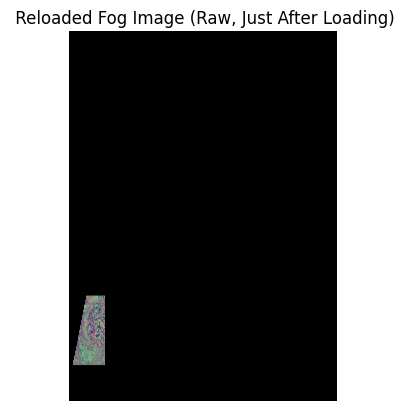

Pixel stats - min: 0, max: 8340


In [ ]:
# Displaying the reloaded fog image (before any processing)
plt.imshow(fog_image.astype(np.uint8))
plt.title(" Reloaded Fog Image (Raw, Just After Loading)")
plt.axis('off')
plt.show()

# Printing pixel value range for sanity check
print(f"Pixel stats - min: {fog_image.min()}, max: {fog_image.max()}")


### **Fallback Image Selection and Reloading**

When the initially chosen fog image lacks meaningful data (e.g., all pixel values are zero), a new image is selected from the list of available `.tif` files.

#### Steps:
1. **Index Shift**:
   - `fog_path = fog_files[2]` selects a new image (e.g., third one in the list), skipping the bad one.

2. **Reload via Rasterio**:
   - Opens the selected file.
   - Retrieves the number of bands in the image.

3. **RGB Handling**:
   - If 3 or more bands: reads the RGB bands `[1, 2, 3]` and converts to shape `(H, W, 3)`.
   - If single-band: replicates it into 3 channels to simulate an RGB image (`Fake RGB`).


This retry mechanism improves robustness by ensuring that the model isn’t fed unusable data, allowing the pipeline to proceed with an alternative fog input.



---



### **Reloading and Verifying the New Fog Image**

In [ ]:
fog_path = fog_files[5]


 Fog Image - Number of bands: 3


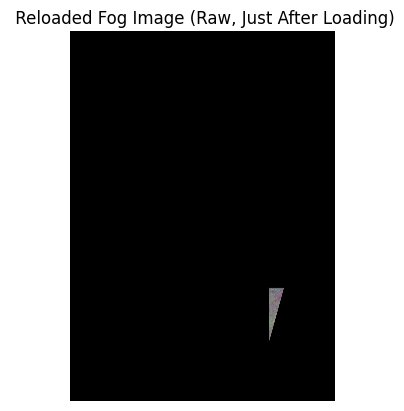

Pixel stats - min: 0, max: 5445


In [ ]:
with rasterio.open(fog_path) as fog_src:
    num_bands = fog_src.count
    print(f" Fog Image - Number of bands: {num_bands}")

    if num_bands >= 3:
        fog_image = fog_src.read([1, 2, 3])
        fog_image = np.moveaxis(fog_image, 0, -1)
    else:
        fog_image = fog_src.read(1)
        fog_image = np.stack([fog_image]*3, axis=-1)

plt.imshow(fog_image.astype(np.uint8))
plt.title(" Reloaded Fog Image (Raw, Just After Loading)")
plt.axis('off')
plt.show()

print(f"Pixel stats - min: {fog_image.min()}, max: {fog_image.max()}")


This step handles the replacement of a failed fog image by reloading an alternative file (in this case, the one at index `fog_files[5]`). Once loaded, the code dynamically checks the number of bands in the image:

- If 3 or more bands are present, it reads the RGB bands `[1, 2, 3]` and reorders them using `np.moveaxis` to get a proper (H, W, C) shape.
- If it's a single-band image, it replicates the grayscale channel to create a pseudo-RGB image using `np.stack`.

After the image is loaded, a simple visualization is rendered to inspect the raw state of the image (before any preprocessing like DCP or normalization). A print statement is also used to confirm the pixel range and check for anomalies (e.g., all black values).

This ensures the fallback file is valid and ready for further processing.



### **Auto-Scanning Fog Dataset for Usable Image**

# Try scanning just the first 50 fog images
 Checked 2 images.
 Found usable fog image: Exported_Image_0.tif


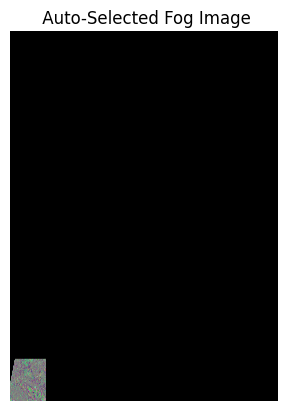

In [ ]:
# Auto-scanning fog files for the first non-black image
valid_fog_path = None

for path in fog_files:
    with rasterio.open(path) as fog_src:
        if fog_src.count >= 3:
            fog_img = fog_src.read([1, 2, 3])
            fog_img = np.moveaxis(fog_img, 0, -1)

            # Checking if image has usable data
            if fog_img.max() > 100:  # Some threshold, not just 0
                valid_fog_path = path
                break

if valid_fog_path:
    print(f"# Try scanning just the first 50 fog images")
valid_fog_path = None
max_files_to_check = 50

for i, path in enumerate(fog_files[:max_files_to_check]):
    with rasterio.open(path) as fog_src:
        if fog_src.count >= 3:
            fog_img = fog_src.read([1, 2, 3])
            fog_img = np.moveaxis(fog_img, 0, -1)

            # If image has enough data
            if fog_img.max() > 100:
                valid_fog_path = path
                break

print(" Checked", i + 1, "images.")

if valid_fog_path:
    print(f" Found usable fog image: {os.path.basename(valid_fog_path)}")

    with rasterio.open(valid_fog_path) as fog_src:
        fog_image = fog_src.read([1, 2, 3])
        fog_image = np.moveaxis(fog_image, 0, -1)

    # Showing the selected fog image
    plt.imshow(fog_image.astype(np.uint8))
    plt.title(" Auto-Selected Fog Image")
    plt.axis('off')
    plt.show()
else:
    print(" No usable image found in the first 50. Try increasing the limit.")
    #The following was indented incorrectly, it should be in the else block
    #Found usable fog image: {os.path.basename(valid_fog_path)}")

    #with rasterio.open(valid_fog_path) as fog_src:
    #    fog_image = fog_src.read([1, 2, 3])
    #    fog_image = np.moveaxis(fog_image, 0, -1)

    # Display
    #plt.imshow(fog_image.astype(np.uint8))
    #plt.title(" Auto-Selected Fog Image (Raw)")
    #plt.axis('off')
    #plt.show()
#else: #This else was also incorrect, extra else
#    print(" No valid fog image found. Try adjusting threshold.")

To avoid errors in later stages caused by black or empty fog images, this section automates the process of scanning a batch of `.tif` files to find a valid image.

- A loop checks each image (up to the first 50 files) for the number of bands and pixel values.
- Images must have at least 3 bands (to simulate RGB) and a maximum pixel value greater than a set threshold (`> 100`) to qualify as valid.
- Once a usable image is found, its path is stored and visualized for verification.

This ensures that the pipeline begins with a meaningful fog image, reducing the likelihood of downstream failures during DCP processing.



### **Step 1: Crop & Resize Usable Fog Image**



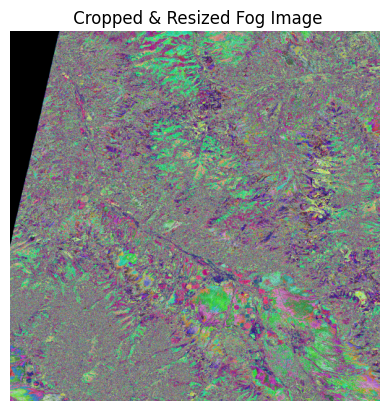

In [ ]:
# Threshold mask for non-black area
mask = np.any(fog_image > 50, axis=2)  # True where any channel > 50
coords = np.argwhere(mask)

if coords.size > 0:
    # Bounding box for valid region
    y0, x0 = coords.min(axis=0)
    y1, x1 = coords.max(axis=0) + 1  # +1 because slicing is exclusive
    fog_cropped = fog_image[y0:y1, x0:x1]

    # Resizing cropped image to 512x512 (or 256x256 later)
    fog_image = cv2.resize(fog_cropped.astype(np.uint8), (512, 512), interpolation=cv2.INTER_AREA)

    plt.imshow(fog_image)
    plt.title(" Cropped & Resized Fog Image")
    plt.axis('off')
    plt.show()
else:
    print(" No valid content found to crop.")


After selecting a valid fog image, the next task is to eliminate any black margins or empty areas that could distort preprocessing steps.

- A threshold mask is applied to detect pixels with sufficient intensity (any channel > 50).
- The smallest bounding box that contains meaningful content is computed using nonzero coordinates.
- This region is extracted and resized to a standardized resolution of **512×512** for consistency.

This preprocessing stage ensures that the input image focuses on actual visual data and not padded or invalid pixels.



---



###**Saving Preprocessed Files**

In [ ]:
# Setting your custom save path
save_dir = "/content/drive/MyDrive/Duweeja de Lima - FYP Folder - 20210522/Data sets/processed"
os.makedirs(save_dir, exist_ok=True)

# Saving fog and wind images as .npy
np.save(f"{save_dir}/fog_image_demo.npy", fog_final)
np.save(f"{save_dir}/wind_data_demo.npy", wind_final)

# Confirming
print(" Saved preprocessed demo inputs for Notebook 2:")
print(f" Fog image → {save_dir}/fog_image_demo.npy")
print(f" Wind data → {save_dir}/wind_data_demo.npy")


 Saved preprocessed demo inputs for Notebook 2:
 Fog image → /content/drive/MyDrive/Duweeja de Lima - FYP Folder - 20210522/Data sets/processed/fog_image_demo.npy
 Wind data → /content/drive/MyDrive/Duweeja de Lima - FYP Folder - 20210522/Data sets/processed/wind_data_demo.npy


### **Saving Preprocessed Data for Model Inference**

Once both the fog and wind images are normalized, resized, and verified, they are stored as NumPy `.npy` files to streamline loading for downstream tasks.

- A **custom save path** is defined for organizing outputs.
- The processed arrays (`fog_final`, `wind_final`) are saved using `np.save()`.
- A **confirmation print** logs the final storage paths.

These `.npy` files will be used as standardized inputs in Notebook 2 for model-level fusion with the **Restormer architecture**.

---



## **Notebook 1: Preprocessing Pipeline Summary**

This notebook established the complete preprocessing pipeline for preparing fog and wind data for model-level fusion.

### **Key Steps Performed**
- **Fog Image Loading**: Satellite fog `.tif` images were loaded using `rasterio`. An initial check revealed some images were entirely black or contained limited valid data.
- **Dark Channel Prior (DCP)**: DCP was applied to reduce fog intensity. However, certain images led to black outputs, triggering a **fallback mechanism**.
- **Fallback Strategy**: When DCP output was fully black (`max = 0`), the original fog image was resized and reused to ensure no data loss in the pipeline.
- **Auto-Selection Logic**: A utility was implemented to scan available fog files and automatically select the first valid image with meaningful pixel content.
- **Image Cropping**: Valid content was extracted by masking non-black regions and applying bounding box cropping, improving the effective area for analysis.
- **Normalization**: Both fog and wind data were normalized to the [0, 1] range for consistency, preparing them for model input.
- **Final Resizing**: All images were resized to a fixed shape of **256×256**, balancing resolution and computational efficiency.
- **Export**: The processed fog and wind arrays were saved as `.npy` files for efficient reuse in the Restormer model pipeline.

### **Key Insights**
- **DCP Limitations**: DCP occasionally fails on sparse or saturated images; fallback and validation checks are essential.
- **Image Integrity**: Pixel distribution, shape, and value ranges were constantly verified to avoid propagating unusable data.
- **Adaptability**: The pipeline is flexible — capable of handling inconsistent image quality across `.tif` files through validation, fallback, and cropping.

---



**- END OF NOTEBOOK 01 -**